In [11]:

import pandas as pd
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import random
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [12]:
data = pd.read_csv(r"datasets/data_by_artist.csv")
data.head()

,mode,count,acousticness,artists,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,9,0.590111,"""Cats"" 1981 Original London Cast",0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5
1,1,26,0.862538,"""Cats"" 1983 Broadway Cast",0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5
2,1,7,0.856571,"""Fiddler On The Roof” Motion Picture Chorus",0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0
3,1,27,0.884926,"""Fiddler On The Roof” Motion Picture Orchestra",0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0
4,1,7,0.510714,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5


In [13]:
artist_data = data[['valence','artists','count','popularity']]
artist_data.to_csv('artist_data.csv')

In [14]:
def PCA_algorithm(data):
    num_datatypes = data.select_dtypes(np.number)      

    pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
    song_embedding = pca_pipeline.fit_transform(num_datatypes)
    return song_embedding

In [15]:
def KMeans_with_PCA_algorithm(song_embedding):
    kmeans_pca = KMeans(n_clusters = 20, init = 'k-means++', random_state=42)     
    label = kmeans_pca.fit(song_embedding)
    centroids = kmeans_pca.cluster_centers_
    return label,centroids

In [16]:
def filter_based_on_segment(df_segm_pca_kmeans,segment_val):    
    #get list of songs with above song id
    #print(df_segm_pca_kmeans[df_segm_pca_kmeans['Segment K-means PCA']==segment_val].values)
    
    filtered_data_per_segment = df_segm_pca_kmeans[df_segm_pca_kmeans['Segment K-means PCA']==segment_val][['artists', 'valence','com1','com2','Segment K-means PCA']]

    #save to csv file
    filtered_data_per_segment.to_csv('filtered_data_per_segment_for_artists.csv')
    return filtered_data_per_segment

In [17]:
def filter_based_on_cluster_centroid(kmeans_pca,filtered_data_per_segment,segment_val,tracks):
    #calculate distance based on cluster centroid
    scaled_data = kmeans_pca.transform( filtered_data_per_segment[['com1','com2']])
    scaled_song_center = kmeans_pca.transform(kmeans_pca.cluster_centers_[segment_val].reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')

    #sort based on distance
    index = list(np.argsort(distances)[0])
    rec_songs = filtered_data_per_segment.iloc[index]
    
    #recommend based on segment data
    # rec_songs = rec_songs[~rec_songs['name'].isin(filtered_data_per_segment['name'])]
    return rec_songs

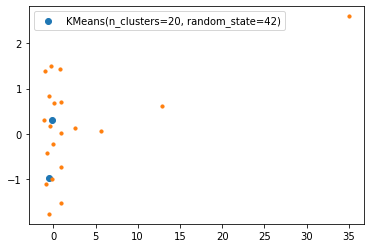

In [18]:
#Importing required modules
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np


df = PCA_algorithm(artist_data)
label,centroids = KMeans_with_PCA_algorithm(df)

#num_datatypes = data.select_dtypes(np.number)   
#pca = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
#df = pca.fit_transform(num_datatypes)

#kmeans = KMeans(n_clusters = 10, init = 'k-means++', random_state=42) 

#label = kmeans.fit_predict(df)
#centroids = kmeans.cluster_centers_
 
#Getting unique labels
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
     plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 10)
plt.legend()
plt.show()

In [19]:
song_embedding = PCA_algorithm(artist_data)
kmeans_pca,centroids = KMeans_with_PCA_algorithm(song_embedding)

df_segm_pca_kmeans = pd.concat([artist_data.reset_index(drop=True), pd.DataFrame(song_embedding)],axis=1)
df_segm_pca_kmeans.columns.values[-2:] = ['com1','com2']
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

#get segment value of artist
artist = 'Frank Sinatra'
segment_val = df_segm_pca_kmeans[df_segm_pca_kmeans['artists'] == artist]['Segment K-means PCA'].values[0]

filtered_data_per_segment = filter_based_on_segment(df_segm_pca_kmeans,segment_val)   

rec_songs = filter_based_on_cluster_centroid(kmeans_pca,filtered_data_per_segment,segment_val,artist_data)

print(rec_songs)

                           artists   valence       com1      com2  \
12170        Johann Sebastian Bach  0.549525  12.976715  0.938996   
27610      Wolfgang Amadeus Mozart  0.324705  12.814141  0.000345   
3004                     Bob Dylan  0.549650  12.605713  0.941866   
4307                        Charlo  0.742842  12.924716  1.705046   
7426                 Elvis Presley  0.617856  13.338832  1.272733   
25487           The Rolling Stones  0.659161  12.373888  1.382649   
15380         Ludwig van Beethoven  0.256824  12.472344 -0.305528   
24342               The Beach Boys  0.629986  12.221201  1.240854   
14179              Lata Mangeshkar  0.647905  12.090485  1.271457   
7353               Ella Fitzgerald  0.397493  12.016990  0.270276   
18056        New York Philharmonic  0.220258  14.051841 -0.353598   
6010                   Dean Martin  0.474576  11.815525  0.570274   
12378                  Johnny Cash  0.672277  14.057666  1.529870   
8638               Frédéric Chopin

In [20]:
p = 0.02  # to randomly select 1% of the rows
df_playlist = pd.read_csv(r"datasets/spotify_dataset.csv", error_bad_lines=False, warn_bad_lines=False, skiprows=lambda i: i>0 and random.random() > p)
df_playlist.head()

,user_id,"""artistname""","""trackname""","""playlistname"""
0,07f0fc3be95dcd878966b1f9572ff670,Marian Pivka & The Budapest Symphonic Orchestra,Ride of the Valkyries,Classique
1,07f0fc3be95dcd878966b1f9572ff670,Daft Punk,Da Funk,Daft Punk
2,07f0fc3be95dcd878966b1f9572ff670,Daft Punk,Robot Rock / Oh Yeah,Daft Punk
3,07f0fc3be95dcd878966b1f9572ff670,Daft Punk,Superheroes / Human After All / Rock'n Roll,Daft Punk
4,07f0fc3be95dcd878966b1f9572ff670,Daft Punk,Television Rules The Nation / Crescendolls,Daft Punk


In [21]:
df_playlist.columns = df_playlist.columns.str.replace('"', '')
df_playlist.columns = df_playlist.columns.str.replace('name', '')
df_playlist.columns = df_playlist.columns.str.replace(' ', '')
df_playlist.columns

Index(['user_id', 'artist', 'track', 'playlist'], dtype='object')

In [22]:
df_playlist = df_playlist.groupby('artist').filter(lambda x : len(x)>=50)
print(df_playlist)

                                 user_id               artist  \
1       07f0fc3be95dcd878966b1f9572ff670            Daft Punk   
2       07f0fc3be95dcd878966b1f9572ff670            Daft Punk   
3       07f0fc3be95dcd878966b1f9572ff670            Daft Punk   
4       07f0fc3be95dcd878966b1f9572ff670            Daft Punk   
5       07f0fc3be95dcd878966b1f9572ff670      Crystal Castles   
...                                  ...                  ...   
257406  488ead471813ae982119153f792e4a3e    Foster The People   
257412  488ead471813ae982119153f792e4a3e                Lorde   
257413  488ead471813ae982119153f792e4a3e             deadmau5   
257418  2302bf9c64dc63d88a750215ed187f2c  Stone Temple Pilots   
257419  2302bf9c64dc63d88a750215ed187f2c            Metallica   

                                              track    playlist  
1                                           Da Funk  Daft Punk   
2                              Robot Rock / Oh Yeah  Daft Punk   
3       Superheroes /

In [23]:
df_playlist = df_playlist[df_playlist.groupby('user_id').artist.transform('nunique') >= 10]
print(df_playlist)

                                 user_id           artist  \
1       07f0fc3be95dcd878966b1f9572ff670        Daft Punk   
2       07f0fc3be95dcd878966b1f9572ff670        Daft Punk   
3       07f0fc3be95dcd878966b1f9572ff670        Daft Punk   
4       07f0fc3be95dcd878966b1f9572ff670        Daft Punk   
5       07f0fc3be95dcd878966b1f9572ff670  Crystal Castles   
...                                  ...              ...   
257276  aedf684d88f71c448add86ee4873278e         Coldplay   
257279  aedf684d88f71c448add86ee4873278e         Anberlin   
257280  aedf684d88f71c448add86ee4873278e    NEEDTOBREATHE   
257281  aedf684d88f71c448add86ee4873278e   Alabama Shakes   
257282  aedf684d88f71c448add86ee4873278e   Alabama Shakes   

                                              track               playlist  
1                                           Da Funk             Daft Punk   
2                              Robot Rock / Oh Yeah             Daft Punk   
3       Superheroes / Human After Al

In [24]:
size = lambda x: len(x)
df_freq = df_playlist.groupby(['user_id', 'artist']).agg('size').reset_index().rename(columns={0:'freq'})[['user_id', 'artist', 'freq']].sort_values(['freq'], ascending=False)
df_freq.head()

,user_id,artist,freq
11097,414050deadb38aafd8d4ad22ca634055,Vitamin String Quartet,67
6808,26b51e580277e131f87e4c7ee4c0887a,Vitamin String Quartet,67
357,014e695cc6df96011b90a5beb3206012,Ilaiyaraaja,57
30733,b1d4116e7cf150ae7d77413620f5f571,Wolfgang Amadeus Mozart,52
43270,fa849dabeb14a2800ad5130907fc5018,Peggy Lee,44


In [25]:
df_artist = pd.DataFrame(df_freq["artist"].unique())
df_artist = df_artist.reset_index()
df_artist = df_artist.rename(columns={'index':'artist_id', 0:'artist'})
df_artist.head()

,artist_id,artist
0,0,Vitamin String Quartet
1,1,Ilaiyaraaja
2,2,Wolfgang Amadeus Mozart
3,3,Peggy Lee
4,4,Ella Fitzgerald


In [26]:
def GetInPut(user):
    inputArtist = pd.DataFrame(user)
    #Filtering out the movies by title
    Id = df_artist[df_artist['artist'].isin(inputArtist['artist'].tolist())]
    #Then merging it so we can get the movieId. It's implicitly merging it by title.
    inputArtist = pd.merge(Id, inputArtist)
    #Dropping information we won't use from the input dataframe
    #inputArtist = inputArtist.drop('year', 1)
    return inputArtist

In [27]:
user = [
            {'artist':'Ella Fitzgerald', 'freq':40},
            {'artist':'Frank Sinatra', 'freq':10},
            {'artist':'Lil Wayne', 'freq':3},
            {'artist':"The Rolling Stones", 'freq':5},
            {'artist':'Louis Armstrong', 'freq':5}
         ] 

In [28]:
inputArtist = GetInPut(user).sort_values('freq',ascending=False)
print(inputArtist)

   artist_id              artist  freq
0          4     Ella Fitzgerald    40
1          5       Frank Sinatra    10
2          8  The Rolling Stones     5
3         11     Louis Armstrong     5
4         17           Lil Wayne     3


In [29]:
print(inputArtist['artist'][0])

Ella Fitzgerald
